# CONUS 404 diagnostic plots

### Input Data Access

- This notebook illustrates how to make diagnostic plots using the CONUS 404 dataset hosted on NCAR's glade storage.
- https://rda.ucar.edu/datasets/d559000/
- This data is open access and can be accessed via 3 protocols 1) posix (if you access to NCAR's HPC) 2) HTTPS 3) OSDF using an intake-ESM catalog.

In [1]:
import warnings
warnings.filterwarnings("ignore")
import intake
import numpy as np
import pandas as pd
import xarray as xr
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# import fsspec.implementations.http as fshttp
# from pelicanfs.core import PelicanFileSystem, PelicanMap, OSDFFileSystem 

In [3]:
import dask 
from dask_jobqueue import PBSCluster
from dask.distributed import Client
from dask.distributed import performance_report

In [14]:
rda_scratch = '/glade/campaign/collections/rda/scratch/harshah'
#cat_url     =  'https://rda.ucar.edu/datasets/d559000/catalogs/d559000_catalog.json'
cat_url     = '/glade/campaign/collections/rda/data/d559000/catalogs/d559000_catalog.json'
print(cat_url)

/glade/campaign/collections/rda/data/d559000/catalogs/d559000_catalog.json


## Create a PBS cluster

In [6]:
# Create a PBS cluster object
cluster = PBSCluster(
    job_name = 'dask-wk24-hpc',
    cores = 1,
    memory = '8GiB',
    processes = 1,
    local_directory = rda_scratch+'/dask/spill',
    log_directory = rda_scratch + '/dask/logs/',
    resource_spec = 'select=1:ncpus=1:mem=8GB',
    queue = 'casper',
    walltime = '5:00:00',
    #interface = 'ib0'
    interface = 'ext'
)

In [7]:
cluster.scale(5)

In [8]:
cluster

Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/harshah/proxy/42645/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://128.117.208.97:39721,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/harshah/proxy/42645/status,Total threads: 0
Started: Just now,Total memory: 0 B


## Load CONUS 404 data from RDA using an intake catalog

In [15]:
col = intake.open_esm_datastore(cat_url)
col

,unique
path,79
variable,206
format,1
short_name,206
long_name,118
units,32
start_time,41
end_time,41
level,0
level_units,0


## Select data and plot

### Temperature
- Plot temperature for a random date

In [57]:
cat_temp = col.search(variable='T2')
cat_temp.df.head()

,path,variable,format,short_name,long_name,units,start_time,end_time,level,level_units,frequency
0,/glade/campaign/collections/rda/data/d559000/k...,T2,reference,T2,NaN,K,1979-10-01,1980-09-30 23:00:00,NaN,NaN,0 days 01:00:00
1,/glade/campaign/collections/rda/data/d559000/k...,T2,reference,T2,NaN,K,1980-10-01,1981-09-30 23:00:00,NaN,NaN,0 days 01:00:00
2,/glade/campaign/collections/rda/data/d559000/k...,T2,reference,T2,NaN,K,1981-10-01,1982-09-30 23:00:00,NaN,NaN,0 days 01:00:00
3,/glade/campaign/collections/rda/data/d559000/k...,T2,reference,T2,NaN,K,1982-10-01,1983-09-30 23:00:00,NaN,NaN,0 days 01:00:00
4,/glade/campaign/collections/rda/data/d559000/k...,T2,reference,T2,NaN,K,1983-10-01,1984-09-30 23:00:00,NaN,NaN,0 days 01:00:00


- The data is organized in (virtual) zarr stores with one water year's worth of data in one file
- Select a year


In [35]:
date = "2020-10-01"
# year = "2021"
cat_temp_subset = cat_temp.search(start_time = date)
cat_temp_subset

,unique
path,1
variable,1
format,1
short_name,1
long_name,0
units,1
start_time,1
end_time,1
level,0
level_units,0


### Load data into xarray

In [36]:
# Load catalog entries for subset into a dictionary of xarray datasets, and open the first one.
dsets = cat_temp_subset.to_dataset_dict(zarr_kwargs={"consolidated": True})
print(f"\nDataset dictionary keys:\n {dsets.keys()}")


--> The keys in the returned dictionary of datasets are constructed as follows:
	'variable.short_name'



Dataset dictionary keys:
 dict_keys(['T2.T2'])


In [41]:
# Load the first dataset and display a summary.
dataset_key = list(dsets.keys())[0]
# store_name = dataset_key + ".zarr"
print(dsets.keys())
ds = dsets[dataset_key]
ds = ds.T2
ds

dict_keys(['T2.T2'])


<xarray.DataArray 'T2' (Time: 8760, south_north: 1015, west_east: 1367)> Size: 49GB
dask.array<open_dataset-T2, shape=(8760, 1015, 1367), dtype=float32, chunksize=(1, 882, 1188), chunktype=numpy.ndarray>
Coordinates:
  * Time     (Time) datetime64[ns] 70kB 2020-10-01 ... 2021-09-30T23:00:00
    XLAT     (Time, south_north, west_east) float32 49GB dask.array<chunksize=(1, 882, 1188), meta=np.ndarray>
    XLONG    (Time, south_north, west_east) float32 49GB dask.array<chunksize=(1, 882, 1188), meta=np.ndarray>
    XTIME    (Time) datetime64[ns] 70kB dask.array<chunksize=(1,), meta=np.ndarray>
Dimensions without coordinates: south_north, west_east
Attributes:
    description:  TEMP at 2 M
    stagger:       
    units:        K

CPU times: user 378 ms, sys: 27.1 ms, total: 405 ms
Wall time: 459 ms


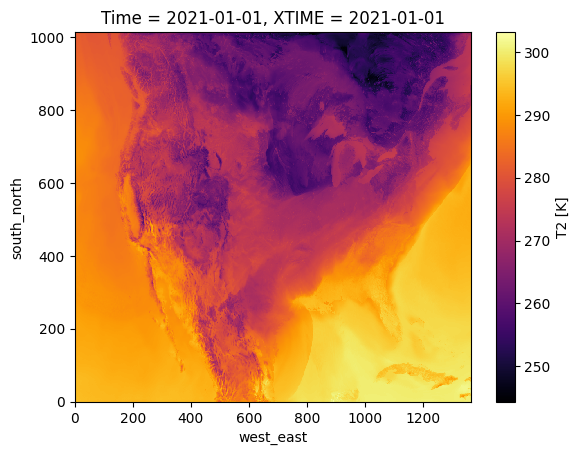

In [58]:
%%time
desired_time = "2021-01-01T00"
ds.sel(Time=desired_date,method='nearest').plot(cmap='inferno')

In [59]:
cluster.close()